<img src="tic3151.png" style="height: 70px; width: 200px" align=left> 
<img src="logo-MMU.png" style="height: 70px; width: 200px" align=right> 

Group Members:

SOON JIE KANG, 1201301760, 011-12788735

LUKE LEE SHAO LIANG, 1191302842, 011-11475018

SATISHNAIR A/L KRISHNAN , 1181103485, 019-7814961

In [9]:
import copy
from random import randint
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import random
import time
import csv
from math import ceil,floor
from constraint import*
import csp
import numpy as np
from IPython.display import display, Markdown, Latex
from sklearn import datasets
import seaborn as sns
import csv
from sklearn import preprocessing
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay
from kneed import KneeLocator

## Question 1

Our scenario contains a total of 6 genes for each chromosome and a total of 100 chromosomes per generation. The 6 genes correspond to hotel star rating, tourist spot, tourist spot spending,food price,transportation fees,transport frequency. The scenario we are setting contains total money on-hand of RM 7000 and duration of 5 days. We assume that each day will need hotel stay per night so a total of 5 days of hotel staying. Total spending at tourist spots will be calculated from the total of tourist spots multiplying the tourist spot spending. As for food price we set it with the assumption of 3 meals per day so the total food price will be 3 times per day for a total of 5 days. For the transportation fees will be calculated total fees multiply frequency for a total of 5 days. 


In [3]:
def individual(length, min, max):
    return [randint(min,max) for x in range(length)]

def individualMutate(min, max):
    return randint(min,max)

def fitness(plan):
    maxLimit = 7000
    duration = 5
    # foodbudget consist of 3 meals per day
    # total = hotelStar * duration + tourSpot * tourBudget + foodBudget * 3 * duration + transBudget * transFreq * 5
    total = plan[0] * duration + plan[1] * plan[2] + plan[3] * 3 * duration + plan[4] * plan[5] * duration
    #in this case fitness the lower the better , fitness is calculated using absolute value of maxLimit - total of current combinations
    fitness = abs(maxLimit - total)
    return fitness

def populate(num,vacPlan):
    totalFitness = 0
    #hotelStar range from 200 to 300 
    hotelStar   = individual(num,200,300)
    #hotelStar range from 2 to 13
    tourSpot    = individual(num,2,13)
    #hotelStar range from 200 to 400
    tourBudget  = individual(num,200,400)
    #hotelStar range from 20 to 30
    foodBudget  = individual(num,20,30)
    #hotelStar range from 40 to 65
    transBudget = individual(num,40,65)
    #hotelStar range from 3 to 8
    transFreq   = individual(num,3,8)
    fitnessValue     = [0]*num
    #this part combines all list generated into a 2d list
    newvacPlan = list(list(x) for x in zip( hotelStar , tourSpot , tourBudget , foodBudget , transBudget, transFreq, fitnessValue))
    for x in range(len(newvacPlan)):
        vacPlan.append(newvacPlan[x])
    #this part calculates the fitness of each chromosome
    for x in range(0,len(vacPlan)):
        vacPlan[x][6]=fitness(vacPlan[x])
        totalFitness+=vacPlan[x][6]
    #we sort the list according to the fitness value in ascending order
    vacPlan = sorted(vacPlan,key=lambda x:x[6])
    return vacPlan,totalFitness

#this function does mutation according to gene choice for the chromosome
def mutate(choice,list):
    match choice:
        case 0:
            list[0]=individualMutate(50,300)
            
        case 1:
            list[1]=individualMutate(2,13)
            
        case 2:
            list[2]=individualMutate(200,400)
            
        case 3:
            list[3]=individualMutate(10,30)
            
        case 4:
            list[4]=individualMutate(30,65)
            
        case 5:
            list[5]=individualMutate(3,8)
            
    
    return list

#this function does the tournament selection of selecting 3 different chromosome and pick the fittest chromosome
def tournamentSelect(vacPlan):
    random.shuffle(vacPlan)
    contestant = []
    for x in range(3):
        contestant.append(vacPlan[x]) 
    winner = min(contestant,key=lambda x:x[6])
    return winner

During the initial population of the genetic algorithm we aim to make the gene as realistic as possible so we set the value in the form of integer and mutation will result in an increase or decrease in form of integer. We set the minimum value for each hotel spending to be RM 200 , minimum tour spot to visit is 2 with basic budget of 200 , food budget of a minimum RM 20, transport budget of minimum RM 40 with minimum 3 trips inclusive of go and back to hotel. 

The fitness value will be calculated from the difference of the money on-hand with the combination of all hotel stays, spending at tourist spots, food price and transport fees. For the genetic algorithm we aim to get the fitness value of 0 which is full utilisation of money on-hand.


In [4]:
"""
Money on-hand | RM 7000
Vacation duration | 5 days
Hotel star rating | <RM300 per night
Tourist spots | 13 spots
One tourist spot | <RM400
Food price | <RM30 per meal - 3 meal per day so total 30*3*5
Transportation fees | <RM65 per trip 
Transport frequency | 8 trip per day - total 65*8*5
Max total = RM 9750
maintain population of 100 every generations
"""
maxLimit=7000
vacPlan =[]
data=[]
overallFitness=[]
#this does the first phase of ga that is population
gen1VacPlan, totalFitness= populate(100,vacPlan)
overallFitness.append(['gen1',totalFitness/100])
# we filter element that have fitness < 0 and repopulate to maintain 100 population, 
# later when selection > crossover > mutation do the same
for x in range(5):
    """
    below is selection by pairing (select pair from top best fitting)
    do selection > crossover > mutation for pairs each time
    """
    
    totalTimeRan=x
    start_time = time.time()
    looptime=0
    bestSolution =[]
    bestFound = True
    vacPlan= copy.deepcopy(gen1VacPlan)
    while bestFound:
        totalFitness=0
        newGeneration = []
        #0-99 in index crossover and mutate
        for x in range(2,100,2):
            father = vacPlan[x-2]
            mother = vacPlan[x-1]
            #single point crossover
            child1 = father[:3] + mother[3:6]
            child2 = mother[:3] + father[3:6]
            #single point mutate the gene of child for this case we use random gene location
            pos_to_mutate = randint(0, 5)
            child1=mutate(pos_to_mutate,child1)
            child2=mutate(pos_to_mutate,child2)
            """
            below segment calculates the fitness of each child and if best solution is found it is saved into the bestSolution
            in the event of best solution found it will still loop until finish and 
            if there are multiple best chromosome only the first one is selected
            """
            child1.append(fitness(child1))
            totalFitness+=fitness(child1)
            if(child1[6]==0):
                bestSolution.append(child1)
                bestFound=False
            child2.append(fitness(child2))
            totalFitness+=fitness(child2)
            if(child2[6]==0):
                bestSolution.append(child2)
                bestFound=False
            newGeneration.append(child1)
            newGeneration.append(child2)
        vacPlan=newGeneration
        overallFitness.append( ['p'+str(totalTimeRan)+'gen',totalFitness/100] )
        looptime= looptime+1
    end_time = time.time()
    timeTaken= end_time - start_time
    #stores only the first best fit chromosome in the event of multiple best chromosome appears
    data.append([bestSolution[0][0],bestSolution[0][1],bestSolution[0][2],bestSolution[0][3],bestSolution[0][4],bestSolution[0][5],looptime,timeTaken])

    """
    below is selection by tournament (select pair from top best fitting)
    """
    
    start_time = time.time()
    looptime=0
    bestSolution =[]
    bestFound = True
    vacPlan= copy.deepcopy(gen1VacPlan)
    while bestFound:
        totalFitness=0
        newGeneration = []
        #0-99 in index crossover and mutate
        for x in range(50):
            father = tournamentSelect(vacPlan)
            #loops until both choice of chromosome are different
            while True:
                mother = tournamentSelect(vacPlan)
                if(father != mother):
                    break
            #single point crossover
            child1 = father[:3] + mother[3:6]
            child2 = mother[:3] + father[3:6]
            #single point mutate the gene of child for this case we use random gene location
            pos_to_mutate = randint(0, 5)
            child1=mutate(pos_to_mutate,child1)
            child2=mutate(pos_to_mutate,child2)
            """
            below segment calculates the fitness of each child and if best solution is found it is saved into the bestSolution
            in the event of best solution found it will still loop until finish and 
            if there are multiple best chromosome only the first one is selected
            """
            child1.append(fitness(child1))
            totalFitness+=fitness(child1)
            if(child1[6]==0):
                bestSolution.append(child1)
                bestFound=False
            child2.append(fitness(child2))
            totalFitness+=fitness(child2)
            if(child2[6]==0):
                bestSolution.append(child2)
                bestFound=False
            newGeneration.append(child1)
            newGeneration.append(child2)
        vacPlan=newGeneration
        overallFitness.append( ['m'+str(totalTimeRan)+'gen',totalFitness/100] )
        looptime= looptime+1
    end_time = time.time()
    timeTaken= end_time - start_time
    #stores only the first best fit chromosome in the event of multiple best chromosome appears
    data.append([bestSolution[0][0],bestSolution[0][1],bestSolution[0][2],bestSolution[0][3],bestSolution[0][4],bestSolution[0][5],looptime,timeTaken])
    
    """
    below is selection by random pairing (select pair by random)
    """
    
    start_time = time.time()
    looptime=0
    bestSolution =[]
    bestFound = True
    while bestFound:
        totalFitness=0
        newGeneration = []
        #0-99 in index crossover and mutate
        for x in range(50):
            father = random.choice(vacPlan)
            #loops until both choice of chromosome are different
            while True:
                mother = random.choice(vacPlan)
                if(father != mother):
                    break
            #single point crossover
            child1 = father[:3] + mother[3:6]
            child2 = mother[:3] + father[3:6]
            #single point mutate the gene of child for this case we use random gene location
            pos_to_mutate = randint(0, 5)
            child1=mutate(pos_to_mutate,child1)
            child2=mutate(pos_to_mutate,child2)
            """
            below segment calculates the fitness of each child and if best solution is found it is saved into the bestSolution
            in the event of best solution found it will still loop until finish and 
            if there are multiple best chromosome only the first one is selected
            """
            child1.append(fitness(child1))
            totalFitness+=fitness(child1)
            if(child1[6]==0):
                bestSolution.append(child1)
                bestFound=False
            child2.append(fitness(child2))
            totalFitness+=fitness(child2)
            if(child2[6]==0):
                bestSolution.append(child2)
                bestFound=False
            newGeneration.append(child1)
            newGeneration.append(child2)
        vacPlan=newGeneration
        overallFitness.append( ['r'+str(totalTimeRan)+'gen',totalFitness/100] )
        looptime= looptime+1
    end_time = time.time()
    timeTaken= end_time - start_time
    #stores only the first best fit chromosome in the event of multiple best chromosome appears
    data.append([bestSolution[0][0],bestSolution[0][1],bestSolution[0][2],bestSolution[0][3],bestSolution[0][4],bestSolution[0][5],looptime,timeTaken])
    #initialize the list to store data
    totalLoop1,totalLoop2,totalLoop3,totalTime1,totalTime2,totalTime3=[0]*6
for x in range(5):
    #this stores the data for each selection of a total of 5 loops
    totalLoop1 = totalLoop1+data[x*3][6]
    totalLoop2 = totalLoop2+data[x*3+1][6]
    totalLoop3 = totalLoop3+data[x*3+2][6]
    totalTime1 = totalTime1+data[x*3][7]
    totalTime2 = totalTime2+data[x*3+1][7]
    totalTime3 = totalTime3+data[x*3+2][7]
with open("q1data.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(data)
with open("q1gen.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(overallFitness)

We modified our selections to form 3 different methods which are pairing selection, tournament selection and random selection. For pairing selection, we pair the chromosomes in odd and even from a list of chromosomes arranged in ascending fitness value. For tournament selection, we pair the chromosome through a selection of 3 chromosomes and select the best fit and assign it for mating with another chromosome chosen in the same manner. For random selection, we select a random pair from the list of chromosomes. For both tournament and random selection, we added a restraint so that there will not be a situation where the pairing for chromosomes is the same.

For our crossover we use a single point crossover where the resulting child chromosome will inherit different half genes of the parent chromosome. Example is child 1 will inherit the first 3 genes of the father chromosome and last 3 genes of the mother chromosome. 

For our mutation we chose to do a random single point mutation for each chromosome before adding into the new generation of chromosomes. Random single point mutation is used so that the variation of chromosome generated will have a diverse variation to avoid reaching a deadlock when trying to find the best fit solution.

The whole process of selection, crossover,mutation will repeat until the best fit solution that uses up all the money on-hand. The calculations will be calculated for average fitness for each new generation. The 3 methods will be run on the same first generation for a total of 5 times to obtain the average generation needed to reach the best fit solution and time taken to finish running the methods.


In [5]:
#This segment divides the fitnessData that stores data of all process into differ dataframe and compared in chart
fitnessData= pd.read_csv('q1gen.csv', header=None)
fitnessData.columns=['Generation','Overall Fitness']
p0=fitnessData.loc[fitnessData['Generation']=='p0gen',['Overall Fitness']]
p0.reset_index(inplace = True, drop = True)
p0.columns=['Pairing Selection 1']
p1=fitnessData.loc[fitnessData['Generation']=='p1gen',['Overall Fitness']]
p1.reset_index(inplace = True, drop = True)
p1.columns=['Pairing Selection 2']
p2=fitnessData.loc[fitnessData['Generation']=='p2gen',['Overall Fitness']]
p2.reset_index(inplace = True, drop = True)
p2.columns=['Pairing Selection 3']
p3=fitnessData.loc[fitnessData['Generation']=='p3gen',['Overall Fitness']]
p3.reset_index(inplace = True, drop = True)
p3.columns=['Pairing Selection 4']
p4=fitnessData.loc[fitnessData['Generation']=='p4gen',['Overall Fitness']]
p4.reset_index(inplace = True, drop = True)
p4.columns=['Pairing Selection 5']
m0=fitnessData.loc[fitnessData['Generation']=='m0gen',['Overall Fitness']]
m0.reset_index(inplace = True, drop = True)
m0.columns=['Tournament Selection 1']
m1=fitnessData.loc[fitnessData['Generation']=='m1gen',['Overall Fitness']]
m1.reset_index(inplace = True, drop = True)
m1.columns=['Tournament Selection 2']
m2=fitnessData.loc[fitnessData['Generation']=='m2gen',['Overall Fitness']]
m2.reset_index(inplace = True, drop = True)
m2.columns=['Tournament Selection 3']
m3=fitnessData.loc[fitnessData['Generation']=='m3gen',['Overall Fitness']]
m3.reset_index(inplace = True, drop = True)
m3.columns=['Tournament Selection 4']
m4=fitnessData.loc[fitnessData['Generation']=='m4gen',['Overall Fitness']]
m4.reset_index(inplace = True, drop = True)
m4.columns=['Tournament Selection 5']
r0=fitnessData.loc[fitnessData['Generation']=='r0gen',['Overall Fitness']]
r0.reset_index(inplace = True, drop = True)
r0.columns=['Random Selection 1']
r1=fitnessData.loc[fitnessData['Generation']=='r1gen',['Overall Fitness']]
r1.reset_index(inplace = True, drop = True)
r1.columns=['Random Selection 2']
r2=fitnessData.loc[fitnessData['Generation']=='r2gen',['Overall Fitness']]
r2.reset_index(inplace = True, drop = True)
r2.columns=['Random Selection 3']
r3=fitnessData.loc[fitnessData['Generation']=='r3gen',['Overall Fitness']]
r3.reset_index(inplace = True, drop = True)
r3.columns=['Random Selection 4']
r4=fitnessData.loc[fitnessData['Generation']=='r4gen',['Overall Fitness']]
r4.reset_index(inplace = True, drop = True)
r4.columns=['Random Selection 5']
#the segment belows combines different dataframe according to respective methods for comparison
combinep=pd.concat([p0,p1,p2,p3,p4],axis=1)
combinep = combinep.reset_index().rename(columns={'index': 'Loop Times/No of Generation'})
combinep.set_index(['Loop Times/No of Generation'], inplace = True)
combinep=combinep.reset_index().melt('Loop Times/No of Generation')

combinem=pd.concat([m0,m1,m2,m3,m4],axis=1)
combinem = combinem.reset_index().rename(columns={'index': 'Loop Times/No of Generation'})
combinem.set_index(['Loop Times/No of Generation'], inplace = True)
combinem=combinem.reset_index().melt('Loop Times/No of Generation')

combiner=pd.concat([r0,r1,r2,r3,r4],axis=1)
combiner = combiner.reset_index().rename(columns={'index': 'Loop Times/No of Generation'})
combiner.set_index(['Loop Times/No of Generation'], inplace = True)
combiner=combiner.reset_index().melt('Loop Times/No of Generation')


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

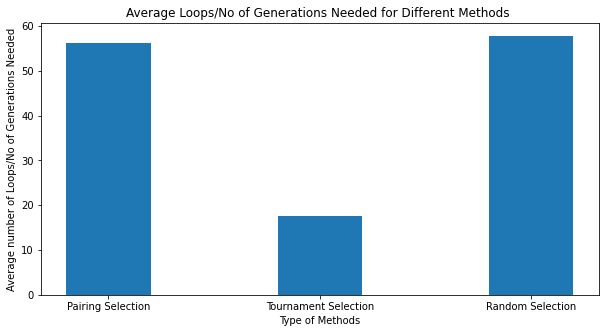

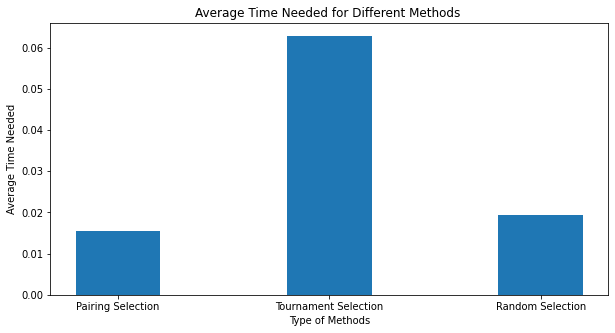

In [6]:
chartp=alt.Chart(combinep,title="Comparison of average fitness for each run time for pairing selection").mark_line().encode(
        alt.Y('value',scale=alt.Scale(zero=False)),
        x='Loop Times/No of Generation',
        #y='value',
        color='variable'
        )

chartm=alt.Chart(combinem,title="Comparison of average fitness for each run time for tournament selection").mark_line().encode(
        alt.Y('value',scale=alt.Scale(zero=False)),
        x='Loop Times/No of Generation',
        #y='value',
        color='variable'
        )

chartr=alt.Chart(combiner,title="Comparison of average fitness for each run time for random selection").mark_line().encode(
        alt.Y('value',scale=alt.Scale(zero=False)),
        x='Loop Times/No of Generation',
        #y='value',
        color='variable'
        )
chartp.display()
chartm.display()
chartr.display()
barData1 = {"Pairing Selection":totalLoop1/5, "Tournament Selection":totalLoop2/5,"Random Selection":totalLoop3/5}
methods = list(barData1.keys())
noLoop = list(barData1.values())
fig1 = plt.figure(figsize = (10, 5))
plt.bar(methods, noLoop, width = 0.4)
plt.xlabel("Type of Methods")
plt.ylabel("Average number of Loops/No of Generations Needed")
plt.title("Average Loops/No of Generations Needed for Different Methods ")
plt.show()
barData2 = {"Pairing Selection":totalTime1/5, "Tournament Selection":totalTime2/5,"Random Selection":totalTime3/5}
methods = list(barData2.keys())
totalTime = list(barData2.values())
fig2 = plt.figure(figsize = (10, 5))
plt.bar(methods, totalTime, width = 0.4)
plt.xlabel("Type of Methods")
plt.ylabel("Average Time Needed")
plt.title("Average Time Needed for Different Methods ")
plt.show()


### Performance Assessment
As we can see the average fitness value of each generation for both pairing selection and random selection gradually increases over generation. While for tournament selection it decreases sharply after first generation. This is mainly because tournament selection selects the fittest chromosome to be mated for next generation but for pairing and random the chromosomes are chosen randomly.

On average the number of generations needed to achieve best fit that uses up all money on-hand the lowest is tournament selection while pairing selection and random selection have nearly identical average number of generations. 

For the average time needed for different methods to complete each run to generate optimal solution for vacation plan, pairing selection has the lowest average time needed followed by random selection that are close to the pairing selection. But for tournament selection it has the highest run time due to it require going through random selection of 3 chromosome before selection fittest chromosome for pairing with another chromosome chosen in the same manner. This resulted in significant time consumed in the selection phases.

As conclusion we can see from the charts tournament selection have the lowest number of generation needed to get optimal solution but longest time needed . While the other two pairing selection and random selection has the identical performance.

## Question 2

In order to generate the optimal solution that is the cheapest and fastest for vaccine distribution based on the data given, constraint satisfaction problem(CSP) is used to find the solution. The process is as follows, formulate the optimal vaccine distribution then based on the distribution formulate the optimal centre needed for distributions. Both the vaccine distribution and centre needed combinations generated from the CSP are then explored based on certain conditions for getting optimal solutions. There are several ways to determine the vaccination solution such as we assume max capacity is used from the start till the end but the vaccination distribution will be imbalanced as the last day will have excess wasted capacity. So we went with determining the optimal vaccine distribution before calculating the vaccine centres needed to finish the vaccine distribution so that there is no excess waste of unused capacity.

There are 3 important functions when formulating the csp that are a finite variable set, a domain set and a finite constraint set. For our vaccine distribution we have total of 6 variables va,vb,vc,finalva,finalvb,finalvc. Variable va,vb,vc correspond to average daily amount of vaccine needed for each type and variable finalva,finalvb,finalvc correspond to final day amount of vaccine needed for each type. The domain of each variable is determined based on the total vaccine amount divided by estimated days needed to finish vaccine distribution.  The constraints added into the CSP are the total vaccine amount of each type for example va + finalva are equal to the total amount of vaccine needed for that particular state. Another constraint is the difference of average and final day distribution for each vaccine does not exceed a certain threshold to ensure distribution is nearly equal throughout the days. The last constraint is the combination of daily and last day vaccine distribution does not exceed the daily limit as specified in the table given. The vaccine distribution with the smallest difference between daily and final day distribution is chosen.


As for our vaccine centre needed we have a total of 5 variables that correspond to each centre type: cr1,cr2,cr3,cr4,cr5. The domain of each centre type is determined by the tables given. There is only one constraint for the CSP that is the total capacity of the centre needed must exceed or equal to max distribution per day as calculated by the vaccine distribution. The cost is then calculated for each possible combination and the smallest cost is chosen for the centres needed.


In [7]:
def calculateDistribution(totalPopulationA,totalPopulationB,totalPopulationC,dailyLimit,cr1range,cr2range,cr3range,cr4range,cr5range):
#assume number of centre used is same from start till end then equally distribute number of vaccine per day based on it
    daysneeded = ceil((totalPopulationA+totalPopulationB+totalPopulationC)/dailyLimit)
    varange = floor(totalPopulationA/(daysneeded))
    vbrange = floor(totalPopulationB/(daysneeded))
    vcrange = floor(totalPopulationC/(daysneeded))
    problem2 = Problem()
    """
    #the variable declaration below ensures that the range for va,vb,vc,finalva,finalvb,finalvc will not deviate more than 150 
    from the initial expected value of varange,vbrange,vcrange that is total number of vacine per type needed divide by daysneeded
    """
    problem2.addVariable("va",[*range(varange-150,varange+150,1)])
    problem2.addVariable("vb",[*range(vbrange-150,vbrange+150,1)])
    problem2.addVariable("vc",[*range(vcrange-150,vcrange+150,1)])
    problem2.addVariable("finalva",[*range(varange-150,varange+150,1)])
    problem2.addVariable("finalvb",[*range(vbrange-150,vbrange+150,1)])
    problem2.addVariable("finalvc",[*range(vcrange-150,vcrange+150,1)])
    """
    the constraint below ensures that all 3 vaccine types are fully distributed after calculation of
    average day distribution * number of days needed -1 + final day distribution
    """
    problem2.addConstraint(lambda va,finalva:va*(daysneeded-1)+finalva==totalPopulationA,("va","finalva"))
    problem2.addConstraint(lambda vb,finalvb:vb*(daysneeded-1)+finalvb==totalPopulationB,("vb","finalvb"))
    problem2.addConstraint(lambda vc,finalvc:vc*(daysneeded-1)+finalvc==totalPopulationC,("vc","finalvc"))
    """
    the constraint below ensures that the maximum difference between average and final day of every vaccine distribution 
    will not exceed the difference of 150, this will significantly reduced the amount of combinations generated and runtime required
    """
    problem2.addConstraint(lambda va,finalva:abs(va-finalva)<=150,("va","finalva"))
    problem2.addConstraint(lambda vb,finalvb:abs(vb-finalvb)<=150,("vb","finalvb"))
    problem2.addConstraint(lambda vc,finalvc:abs(vc-finalvc)<=150,("vc","finalvc"))
    """
    the constraint below ensures that total of average and final day distribution will not exceed the daily limit inposed
    """
    problem2.addConstraint(lambda va,vb,vc:va+vb+vc <=dailyLimit,["va","vb","vc"])
    problem2.addConstraint(lambda finalva,finalvb,finalvc:finalva+finalvb+finalvc <=dailyLimit,["finalva","finalvb","finalvc"])
    solutions2=problem2.getSolutions()
    """
    this part will calculate the maximum population needed to cover per day to achieve optimum distribution 
    and also the difference between average daily and final day distribution
    """
    for a in range(len(solutions2)):
        solutions2[a]['differ'] =  ( abs(solutions2[a]['finalva']-solutions2[a]['va']) + abs(solutions2[a]['finalvb']-solutions2[a]['vb']) + abs(solutions2[a]['finalvc']-solutions2[a]['vc']) )
        maxb=solutions2[a]['finalva']+solutions2[a]['finalvb']+solutions2[a]['finalvc']
        maxa=solutions2[a]['va']+solutions2[a]['vb']+solutions2[a]['vc']
        if(maxa>maxb):
            maxpop=maxa
        else:
            maxpop=maxb
        maxpop -= maxpop % -100
        solutions2[a]['maxpop']=maxpop
    #this will sort the vaccineList according to the ascending value of difference calculated
    vaccineList = sorted(solutions2,key=lambda x:x['differ'])
    vaccineDistribution=min(solutions2,key=lambda x:x['differ'])
    """
    this part will calculate whether which one have the highest population needed among average daily and final day distribution
    and round off to nearest 100 ceiling value
    """
    maxb=vaccineDistribution['finalva']+vaccineDistribution['finalvb']+vaccineDistribution['finalvc']
    maxa=vaccineDistribution['va']+vaccineDistribution['vb']+vaccineDistribution['vc']
    if(maxa>maxb):
        maxpop=maxa
    else:
        maxpop=maxb
    maxpop -= maxpop % -100
    """
    the part below calculates all possible combinations of vaccine centres needed to cover the daily distribution based on 
    the maxpop calculated 
    """
    problem = Problem()
    problem.addVariable("cr1",[*range(0,cr1range+1,1)])
    problem.addVariable("cr2",[*range(0,cr2range+1,1)])
    problem.addVariable("cr3",[*range(0,cr3range+1,1)])
    problem.addVariable("cr4",[*range(0,cr4range+1,1)])
    problem.addVariable("cr5",[*range(0,cr5range+1,1)])
    #the constraint for maximum vaccination limit
    problem.addConstraint(lambda cr1,cr2,cr3,cr4,cr5:cr1*200 + cr2*500 + cr3*1000 + cr4*2500 + cr5*4000 >= maxpop,("cr1","cr2","cr3","cr4","cr5"))
    solutions=problem.getSolutions()
    #this loop will generate the cost for all possible combinations generated using csp above
    for a in range(len(solutions)):
        solutions[a]['cost'] = solutions[a]['cr1']*100 + solutions[a]['cr2']*250 +solutions[a]['cr3']*500 + solutions[a]['cr4']*800 + solutions[a]['cr5']*1200
    #this will sort the centreList according to the ascending value of cost needed
    centreList = sorted(solutions,key=lambda x:x['cost'])
    totalCentre =min(solutions,key=lambda x:x['cost'])
    centres = list(totalCentre.values())
    #below is the display of vaccination details for each states
    centreNeeded = "Vaccination Centre Type Needed             : "
    for a in range(5):
        if(totalCentre['cr'+str(a+1)]!=0):
            centreNeeded +=  "Centre " + str(a+1) + " x " + str(totalCentre['cr'+str(a+1)] ) + " "
    print("Total Day Needed         : " + str(daysneeded) + " Days")
    print("Rental per day           : RM " + str(centreList[0]['cost']))
    print("Total Vaccine A per day  : " + str(vaccineList[0]['va']))
    print("Total Vaccine A last day : " + str(vaccineList[0]['finalva']))
    print("Total Vaccine B per day  : " + str(vaccineList[0]['vb']))
    print("Total Vaccine B last day : " + str(vaccineList[0]['finalvb']))
    print("Total Vaccine C per day  : " + str(vaccineList[0]['vc']))
    print("Total Vaccine C last day : " + str(vaccineList[0]['finalvc']))
    print("Maximum total vaccine distribution per day : " + str(maxpop))
    print(centreNeeded)
    print()
    return vaccineList, centreList
"""
#displayCalculations will display top combinations for both vaccination distribution and 
also cost of different vaccine centres
"""
def displayCalculations(text,vaccineList,centreList):
    print(text)
    print("Top vaccine distribution for the smallest difference between final day and average day distribution")
    print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Vaccine A','Vaccine B','Vaccine C', 'Final VA','Final VB','Final VC','Total Difference'))
    length=len(vaccineList)
    if(length>5):
        length=5
    for x in range(length):
        print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(vaccineList[x]['va'],vaccineList[x]['vb'],vaccineList[x]['vc'], vaccineList[x]['finalva'],vaccineList[x]['finalvb'],vaccineList[x]['finalvc'],vaccineList[x]['differ']))
    print()
    print("Top cheapest vaccine centre usage")
    length=len(centreList)
    if(length>5):
        length=5
    for x in range(length):
        centreNeeded = "Total cost of RM " + str(centreList[x]['cost']) + " :"
        for a in range(5):
            if(centreList[x]['cr'+str(a+1)]!=0):
                centreNeeded +=  "Centre " + str(a+1) + " x " + str(centreList[x]['cr'+str(a+1)] ) + " "
        print(centreNeeded)
    print()

In [10]:
#assume number of centre used is same from start till end then equally distribute number of vaccine per day based on it
print("ST1")
vaccineList1, centreList1 =calculateDistribution(15000,434890,115900,5000,20,15,10,21,5)
print("ST2")
vaccineList2, centreList2 =calculateDistribution(35234,378860,100450,10000,30,16,15,10,2)
print("ST3")
vaccineList3, centreList3 =calculateDistribution(22318,643320,223400,7500,22,15,11,12,3)
print("ST4")
vaccineList4, centreList4 =calculateDistribution(23893,859900,269300,8500,16,16,16,15,1)
print("ST5")
vaccineList5, centreList5 =calculateDistribution(19284,450500,221100,9500,19,10,20,15,1)


displayCalculations("Combinations For ST1",vaccineList1,centreList1)
displayCalculations("Combinations For ST2",vaccineList2,centreList2)
displayCalculations("Combinations For ST3",vaccineList3,centreList3)
displayCalculations("Combinations For ST4",vaccineList4,centreList4)
displayCalculations("Combinations For ST5",vaccineList5,centreList5)

ST1
Total Day Needed         : 114 Days
Rental per day           : RM 1600
Total Vaccine A per day  : 132
Total Vaccine A last day : 84
Total Vaccine B per day  : 3815
Total Vaccine B last day : 3795
Total Vaccine C per day  : 1017
Total Vaccine C last day : 979
Maximum total vaccine distribution per day : 5000
Vaccination Centre Type Needed             : Centre 4 x 2 

ST2
Total Day Needed         : 52 Days
Rental per day           : RM 3200
Total Vaccine A per day  : 678
Total Vaccine A last day : 656
Total Vaccine B per day  : 7286
Total Vaccine B last day : 7274
Total Vaccine C per day  : 1932
Total Vaccine C last day : 1918
Maximum total vaccine distribution per day : 9900
Vaccination Centre Type Needed             : Centre 4 x 1 Centre 5 x 2 

ST3
Total Day Needed         : 119 Days
Rental per day           : RM 2400
Total Vaccine A per day  : 188
Total Vaccine A last day : 134
Total Vaccine B per day  : 5406
Total Vaccine B last day : 5412
Total Vaccine C per day  : 1877
Total V

In [11]:
#this part saves all data generated into the csv
keys1 = vaccineList1[0].keys()
keys2 = centreList1[0].keys()
with open('st1vac.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys1)
    dict_writer.writeheader()
    dict_writer.writerows(vaccineList1)
with open('st1centre.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys2)
    dict_writer.writeheader()
    dict_writer.writerows(centreList1)
with open('st2vac.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys1)
    dict_writer.writeheader()
    dict_writer.writerows(vaccineList2)
with open('st2centre.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys2)
    dict_writer.writeheader()
    dict_writer.writerows(centreList2)
with open('st3vac.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys1)
    dict_writer.writeheader()
    dict_writer.writerows(vaccineList3)
with open('st3centre.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys2)
    dict_writer.writeheader()
    dict_writer.writerows(centreList3)
with open('st4vac.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys1)
    dict_writer.writeheader()
    dict_writer.writerows(vaccineList4)
with open('st4centre.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys2)
    dict_writer.writeheader()
    dict_writer.writerows(centreList4)
with open('st5vac.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys1)
    dict_writer.writeheader()
    dict_writer.writerows(vaccineList5)
with open('st5centre.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys2)
    dict_writer.writeheader()
    dict_writer.writerows(centreList5)

## Question 3

## Read Data

In [12]:
df = pd.read_csv('Bank_CreditScoring.csv')
df.head()

Credit_Card_Exceed_Months Employment_Type  Loan_Amount  Loan_Tenure_Year  \
0                          1        employer       456509                16   
1                          1        employer       605505                19   
2                          1        employer       294133                19   
3                          1        employer       490216                20   
4                          1        employer       292728                14   

  More_Than_One_Products  Credit_Card_More_Than_Months  Number_of_Dependents  \
0                    yes                             1                     2   
1                     no                             1                     2   
2                    yes                             1                     2   
3                     no                             1                     2   
4                    yes                             1                     2   

   Years_to_Financial_Freedom  Number_of_Credit_Card_Facility  \
0                           5                               2   
1                           5                               2   
2                           5                               2   
3                           5                               2   
4                           5                               2   

   Number_of_Properties  ...  Number_of_Loan_to_Approve  Property_Type  \
0                     2  ...                          1    condominium   
1                     2  ...                          2    condominium   
2                     2  ...                          3    condominium   
3                     2  ...                          1    condominium   
4                     2  ...                          2    condominium   

  Years_for_Property_to_Completion  State Number_of_Side_Income  \
0                               10  Johor                     2   
1                               10  Johor                     2   
2                               10  Johor                     2   
3                               10  Johor                     1   
4                               10  Johor                     3   

   Monthly_Salary  Total_Sum_of_Loan  Total_Income_for_Join_Application  \
0           12262             853141                              16025   
1            9251             882901                              17082   
2            4919             540489                              12613   
3            4459             536727                              10952   
4            5628             774695                              11209   

   Decision Score  
0    Reject     7  
1    Accept     9  
2    Reject     8  
3    Accept     9  
4    Reject     8  

[5 rows x 21 columns]

## Check data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Credit_Card_Exceed_Months          2350 non-null   int64 
 1   Employment_Type                    2350 non-null   object
 2   Loan_Amount                        2350 non-null   int64 
 3   Loan_Tenure_Year                   2350 non-null   int64 
 4   More_Than_One_Products             2350 non-null   object
 5   Credit_Card_More_Than_Months       2350 non-null   int64 
 6   Number_of_Dependents               2350 non-null   int64 
 7   Years_to_Financial_Freedom         2350 non-null   int64 
 8   Number_of_Credit_Card_Facility     2350 non-null   int64 
 9   Number_of_Properties               2350 non-null   int64 
 10  Number_of_Bank_Products            2350 non-null   int64 
 11  Number_of_Loan_to_Approve          2350 non-null   int64 
 12  Proper

### Check categorical data

In [14]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Employment_Type', 'More_Than_One_Products', 'Property_Type', 'State', 'Decision']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Employment_Type:** employer, Self_Employed, government, employee, Fresh_Graduate, 

**More_Than_One_Products:** yes, no, 

**Property_Type:** condominium, bungalow, terrace, flat, 

**State:** Johor, Selangor, Kuala Lumpur, Penang, P.Pinang, Pulau Penang, Johor B, K.L, N.Sembilan, N.S, Sarawak, Sabah, SWK, Trengganu, Kedah, 

**Decision:** Reject, Accept, 

From above exploration:

All the columns, i.e. "Employment_Type", "More_Than_One_Products", "Property_Type", "State" and "Decision" are Nominal data.


In [16]:
# It is found that there are some inconsistencies in spelling some of the states. E.g., Penang, P.Pinang and Pulau Penang.
# So, we need to correct them
replacement_mapping_dict = {
    "Johor B": "Johor",
    "P.Pinang": "Penang",
    "Pulau Penang": "Penang",
    "K.L": "Kuala Lumpur",
    "N.Sembilan": "Negeri Sembilan",
    "N.S": "Negeri Sembilan",
    "SWK": "Sarawak",
    "Trengganu": "Terengganu"
}
df["State"].replace(replacement_mapping_dict, inplace=True)
df.State.unique()

array(['Johor', 'Selangor', 'Kuala Lumpur', 'Penang', 'Negeri Sembilan',
       'Sarawak', 'Sabah', 'Terengganu', 'Kedah'], dtype=object)

## Encoding

In [18]:
category_col =['Employment_Type', 'More_Than_One_Products', 'Property_Type', 'State', 'Decision']  
labelEncoder = preprocessing.LabelEncoder() 
  
mapping_dict ={} 
for col in category_col: 
    df[col] = labelEncoder.fit_transform(df[col]) 
  
    le_name_mapping = dict(zip(labelEncoder.classes_, 
                        labelEncoder.transform(labelEncoder.classes_))) 
  
    mapping_dict[col]= le_name_mapping 
print(mapping_dict) 

{'Employment_Type': {'Fresh_Graduate': 0, 'Self_Employed': 1, 'employee': 2, 'employer': 3, 'government': 4}, 'More_Than_One_Products': {'no': 0, 'yes': 1}, 'Property_Type': {'bungalow': 0, 'condominium': 1, 'flat': 2, 'terrace': 3}, 'State': {'Johor': 0, 'Kedah': 1, 'Kuala Lumpur': 2, 'Negeri Sembilan': 3, 'Penang': 4, 'Sabah': 5, 'Sarawak': 6, 'Selangor': 7, 'Terengganu': 8}, 'Decision': {'Accept': 0, 'Reject': 1}}


## Exploratory Data Analysis

In [19]:
#Descriptive Statistics
df.describe()

Credit_Card_Exceed_Months  Employment_Type    Loan_Amount  \
count                2350.000000      2350.000000    2350.000000   
mean                    4.723404         1.702128  448350.120851   
std                     2.101127         1.367302  202814.886797   
min                     1.000000         0.000000  100194.000000   
25%                     3.000000         1.000000  273169.250000   
50%                     5.000000         2.000000  447251.500000   
75%                     7.000000         3.000000  623714.000000   
max                     7.000000         4.000000  799628.000000   

       Loan_Tenure_Year  More_Than_One_Products  Credit_Card_More_Than_Months  \
count       2350.000000             2350.000000                    2350.00000   
mean          17.053191                0.500000                       2.12766   
std            4.352123                0.500106                       1.40874   
min           10.000000                0.000000                       1.00000   
25%           13.000000                0.000000                       1.00000   
50%           17.000000                0.500000                       1.00000   
75%           21.000000                1.000000                       3.00000   
max           24.000000                1.000000                       5.00000   

       Number_of_Dependents  Years_to_Financial_Freedom  \
count            2350.00000                 2350.000000   
mean                3.12766                   13.382979   
std                 1.40874                    4.067090   
min                 2.00000                    5.000000   
25%                 2.00000                   10.000000   
50%                 2.00000                   14.000000   
75%                 4.00000                   17.000000   
max                 6.00000                   19.000000   

       Number_of_Credit_Card_Facility  Number_of_Properties  ...  \
count                     2350.000000           2350.000000  ...   
mean                         3.744681              2.382979  ...   
std                          1.391271              0.813707  ...   
min                          2.000000              2.000000  ...   
25%                          2.000000              2.000000  ...   
50%                          4.000000              2.000000  ...   
75%                          5.000000              2.000000  ...   
max                          6.000000              5.000000  ...   

       Number_of_Loan_to_Approve  Property_Type  \
count                2350.000000    2350.000000   
mean                    1.991915       1.493617   
std                     0.816717       1.053568   
min                     1.000000       0.000000   
25%                     1.000000       1.000000   
50%                     2.000000       1.000000   
75%                     3.000000       2.000000   
max                     3.000000       3.000000   

       Years_for_Property_to_Completion        State  Number_of_Side_Income  \
count                       2350.000000  2350.000000            2350.000000   
mean                          10.659574     2.876596               2.020426   
std                            1.077590     2.208214               0.818325   
min                           10.000000     0.000000               1.000000   
25%                           10.000000     2.000000               1.000000   
50%                           10.000000     2.000000               2.000000   
75%                           11.000000     4.000000               3.000000   
max                           13.000000     8.000000               3.000000   

       Monthly_Salary  Total_Sum_of_Loan  Total_Income_for_Join_Application  \
count     2350.000000       2.350000e+03                        2350.000000   
mean      7972.040000       9.435756e+05                       13767.859574   
std       2588.330436       2.909033e+05                        3591.707735   
min       3583.000000       4.2

Text(0.5, 1.0, 'Decision Accept VS Reject')

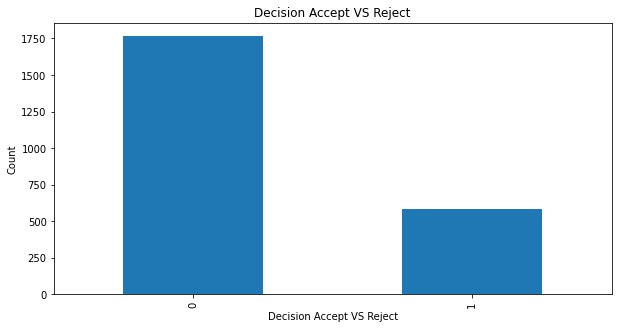

In [20]:
plt.figure(figsize=(10,5))
ax = df.Decision.value_counts().plot(kind = 'bar')
plt.xlabel("Decision Accept VS Reject")
plt.ylabel("Count")
plt.title("Decision Accept VS Reject")
#  0=Accept; 1 = Reject

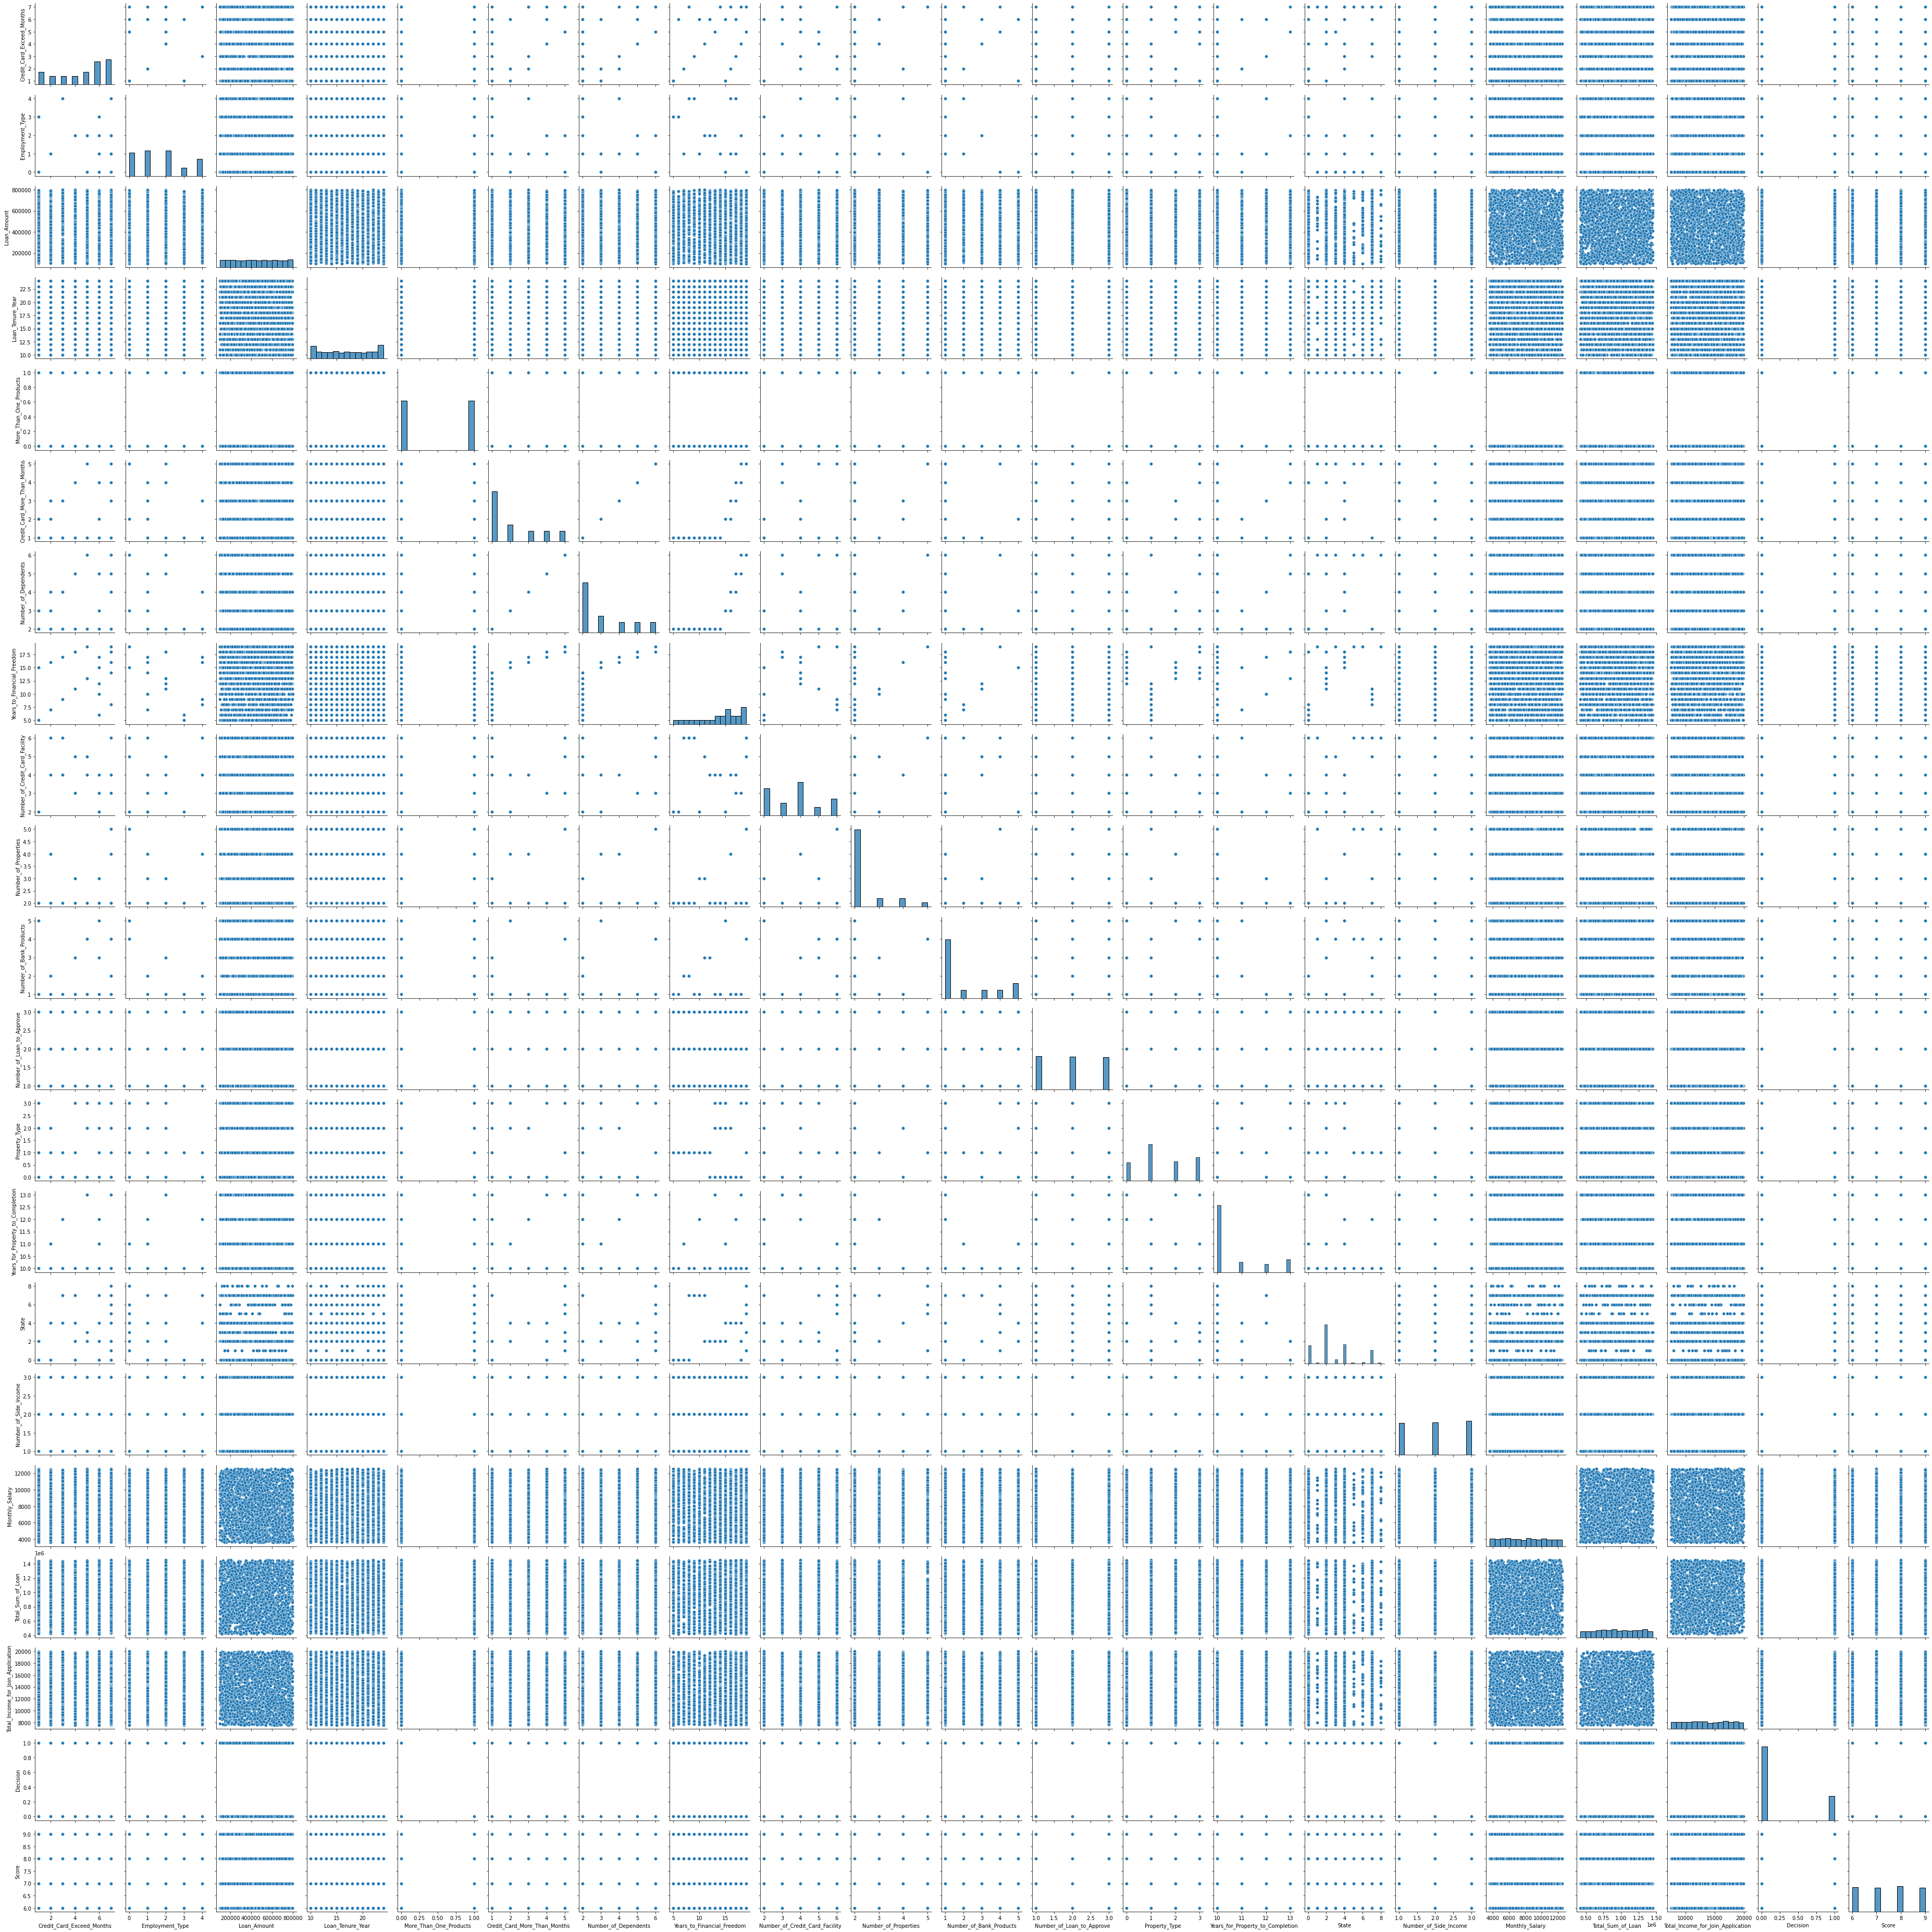

In [21]:
sns.pairplot(df)

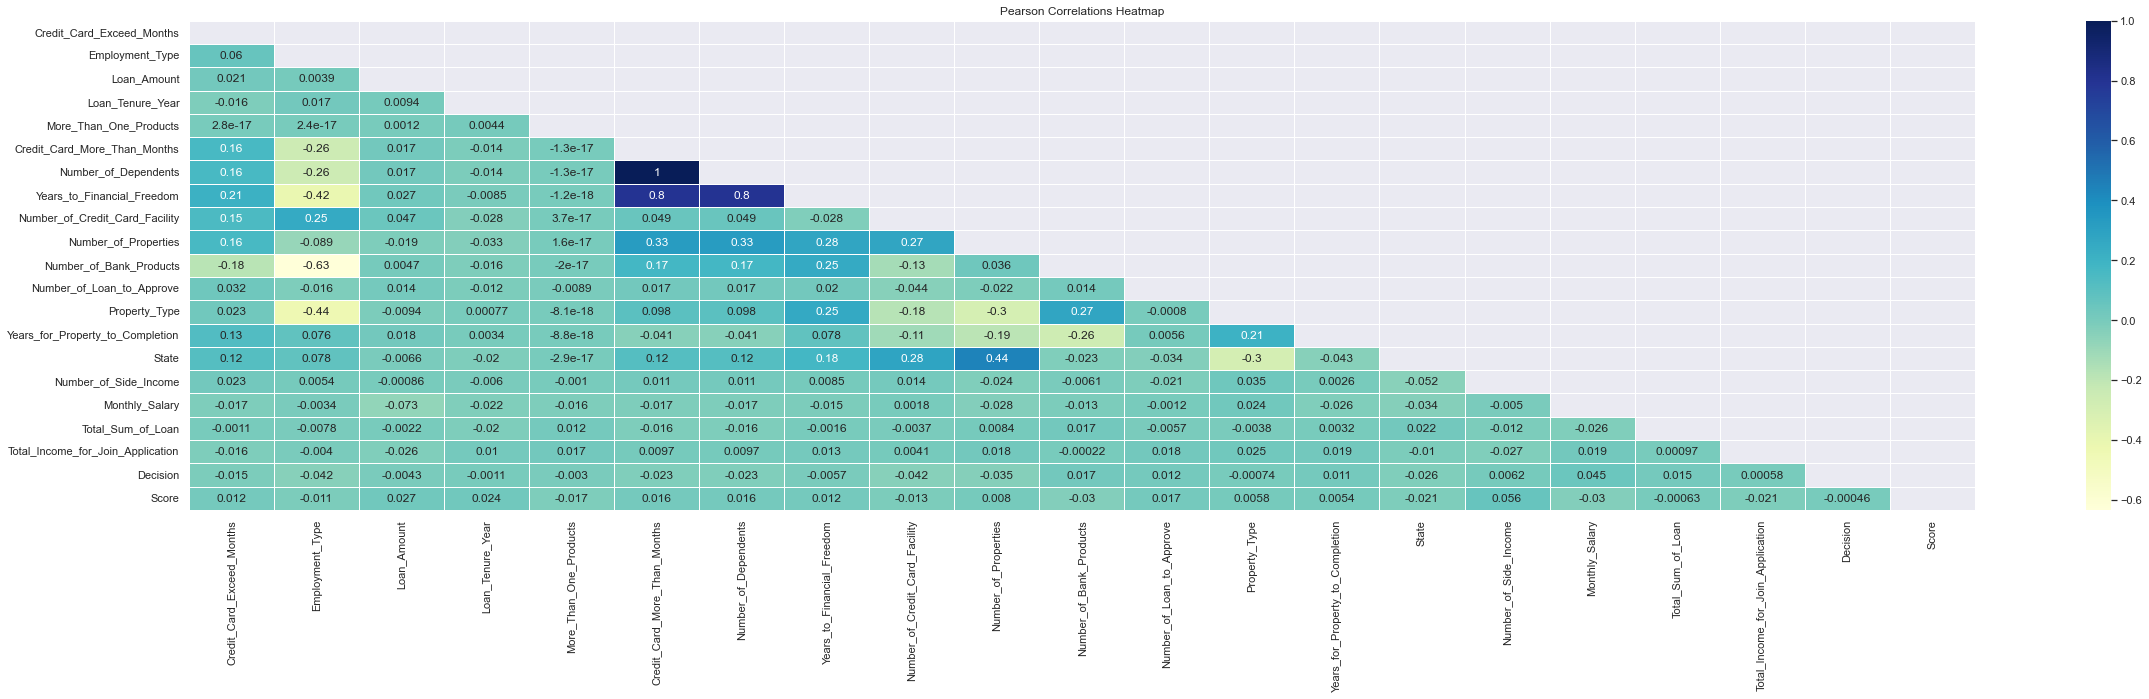

In [22]:
# Heatmap to find any high correlations
corr = df.corr()
sns.set(rc={'figure.figsize':(40,9)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr, dtype=bool)))\
    .set_title("Pearson Correlations Heatmap");

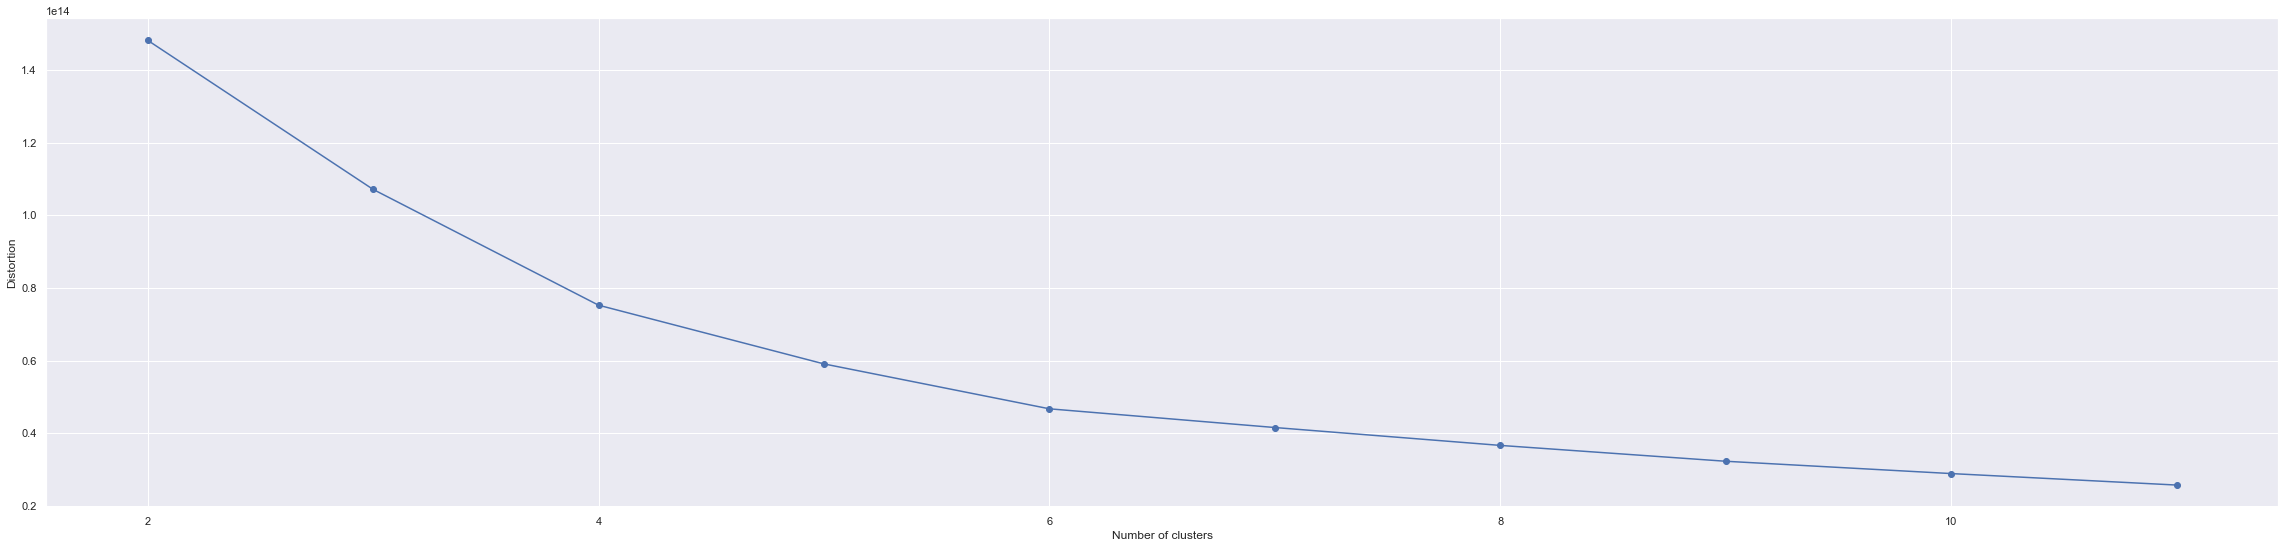

In [23]:
sse = []
for i in range(2,12):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=50, max_iter=500,
        random_state=0, algorithm='elkan'
    )
    km.fit(df)
    sse.append(km.inertia_)
    
plt.plot(range(2,12), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [24]:
# Identify the elbow for the number of clusters
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )
kl.elbow

4

In [25]:
silhouette_coefficients = []
for i in range(2, 12):
    km = KMeans(
    n_clusters=i, init='k-means++',
    n_init=50, max_iter=500,
    random_state=0, algorithm='elkan'
    )
    km.fit(df)
    score = silhouette_score(df, km.labels_)
    silhouette_coefficients.append(score)

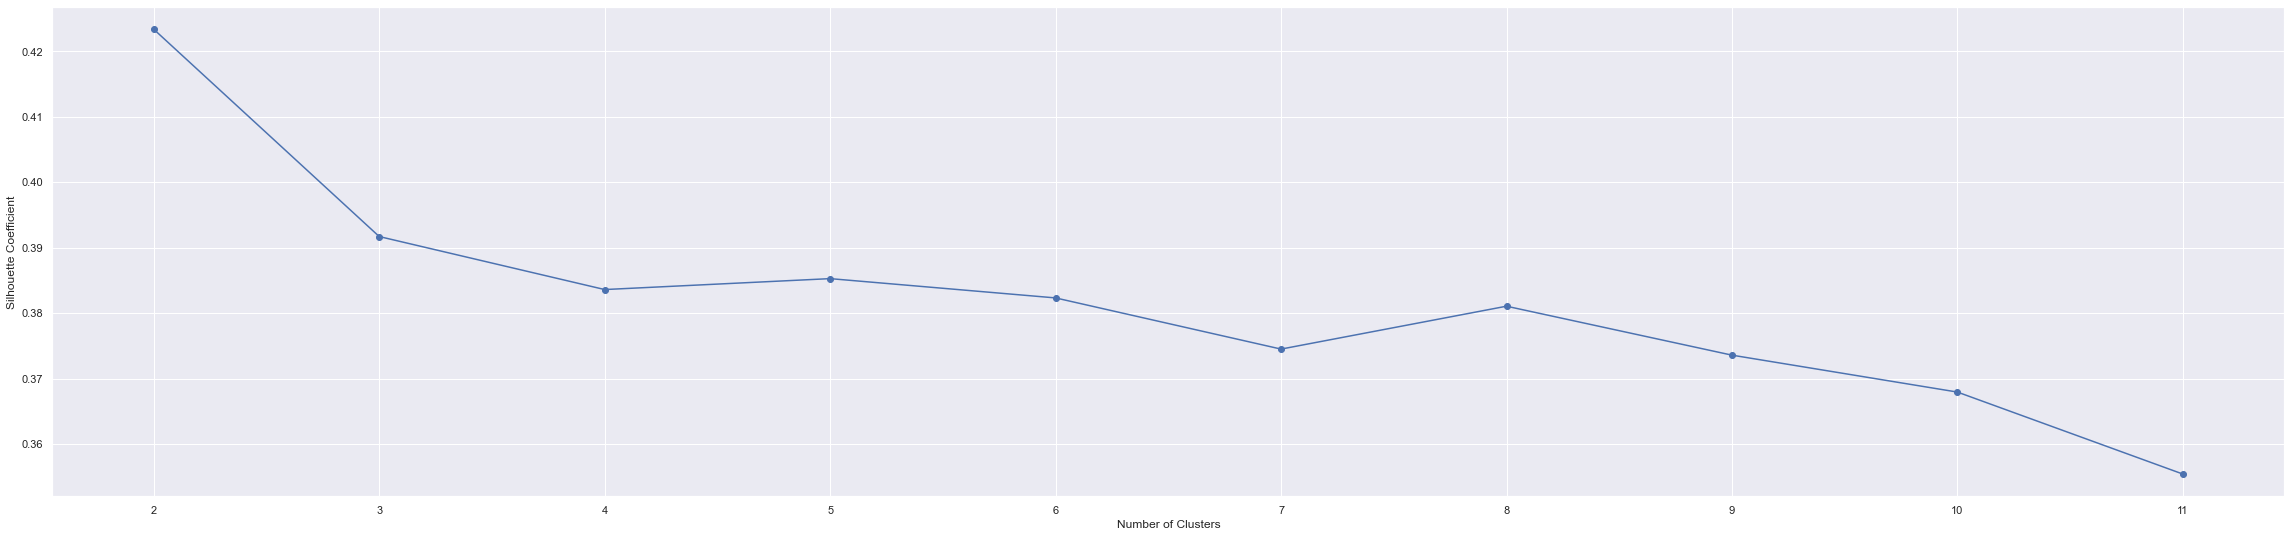

In [26]:
plt.plot(range(2, 12), silhouette_coefficients, marker='o')
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

We explore Elbow Method and Silhouette Coefficients to find the optimal number of clusters for KMeans Clustering. However, we decide to use number of clusters from elbow method (k=4) because the Silhouette Coefficients are low. By right, 
+1 means clusters are clearly distinguished, 0 means clusters are neutral in nature and can not be distinguished properly, and -1 means the clusters are assigned in the wrong way. Based on the graph, The highest Silhouette Coefficient is found to be approximately 0.425 only when number of clusters is 2. The value 0.425 is quite low and it means that the clusters are somewhat not distinguishable. 

In [27]:
km = KMeans(
    n_clusters=4, init='k-means++',
    n_init=50, max_iter=500,
    random_state=0, algorithm='elkan'
    )
clusters = km.fit_predict(df)

df_clustered = df.copy()
df_clustered["Cluster"] = clusters

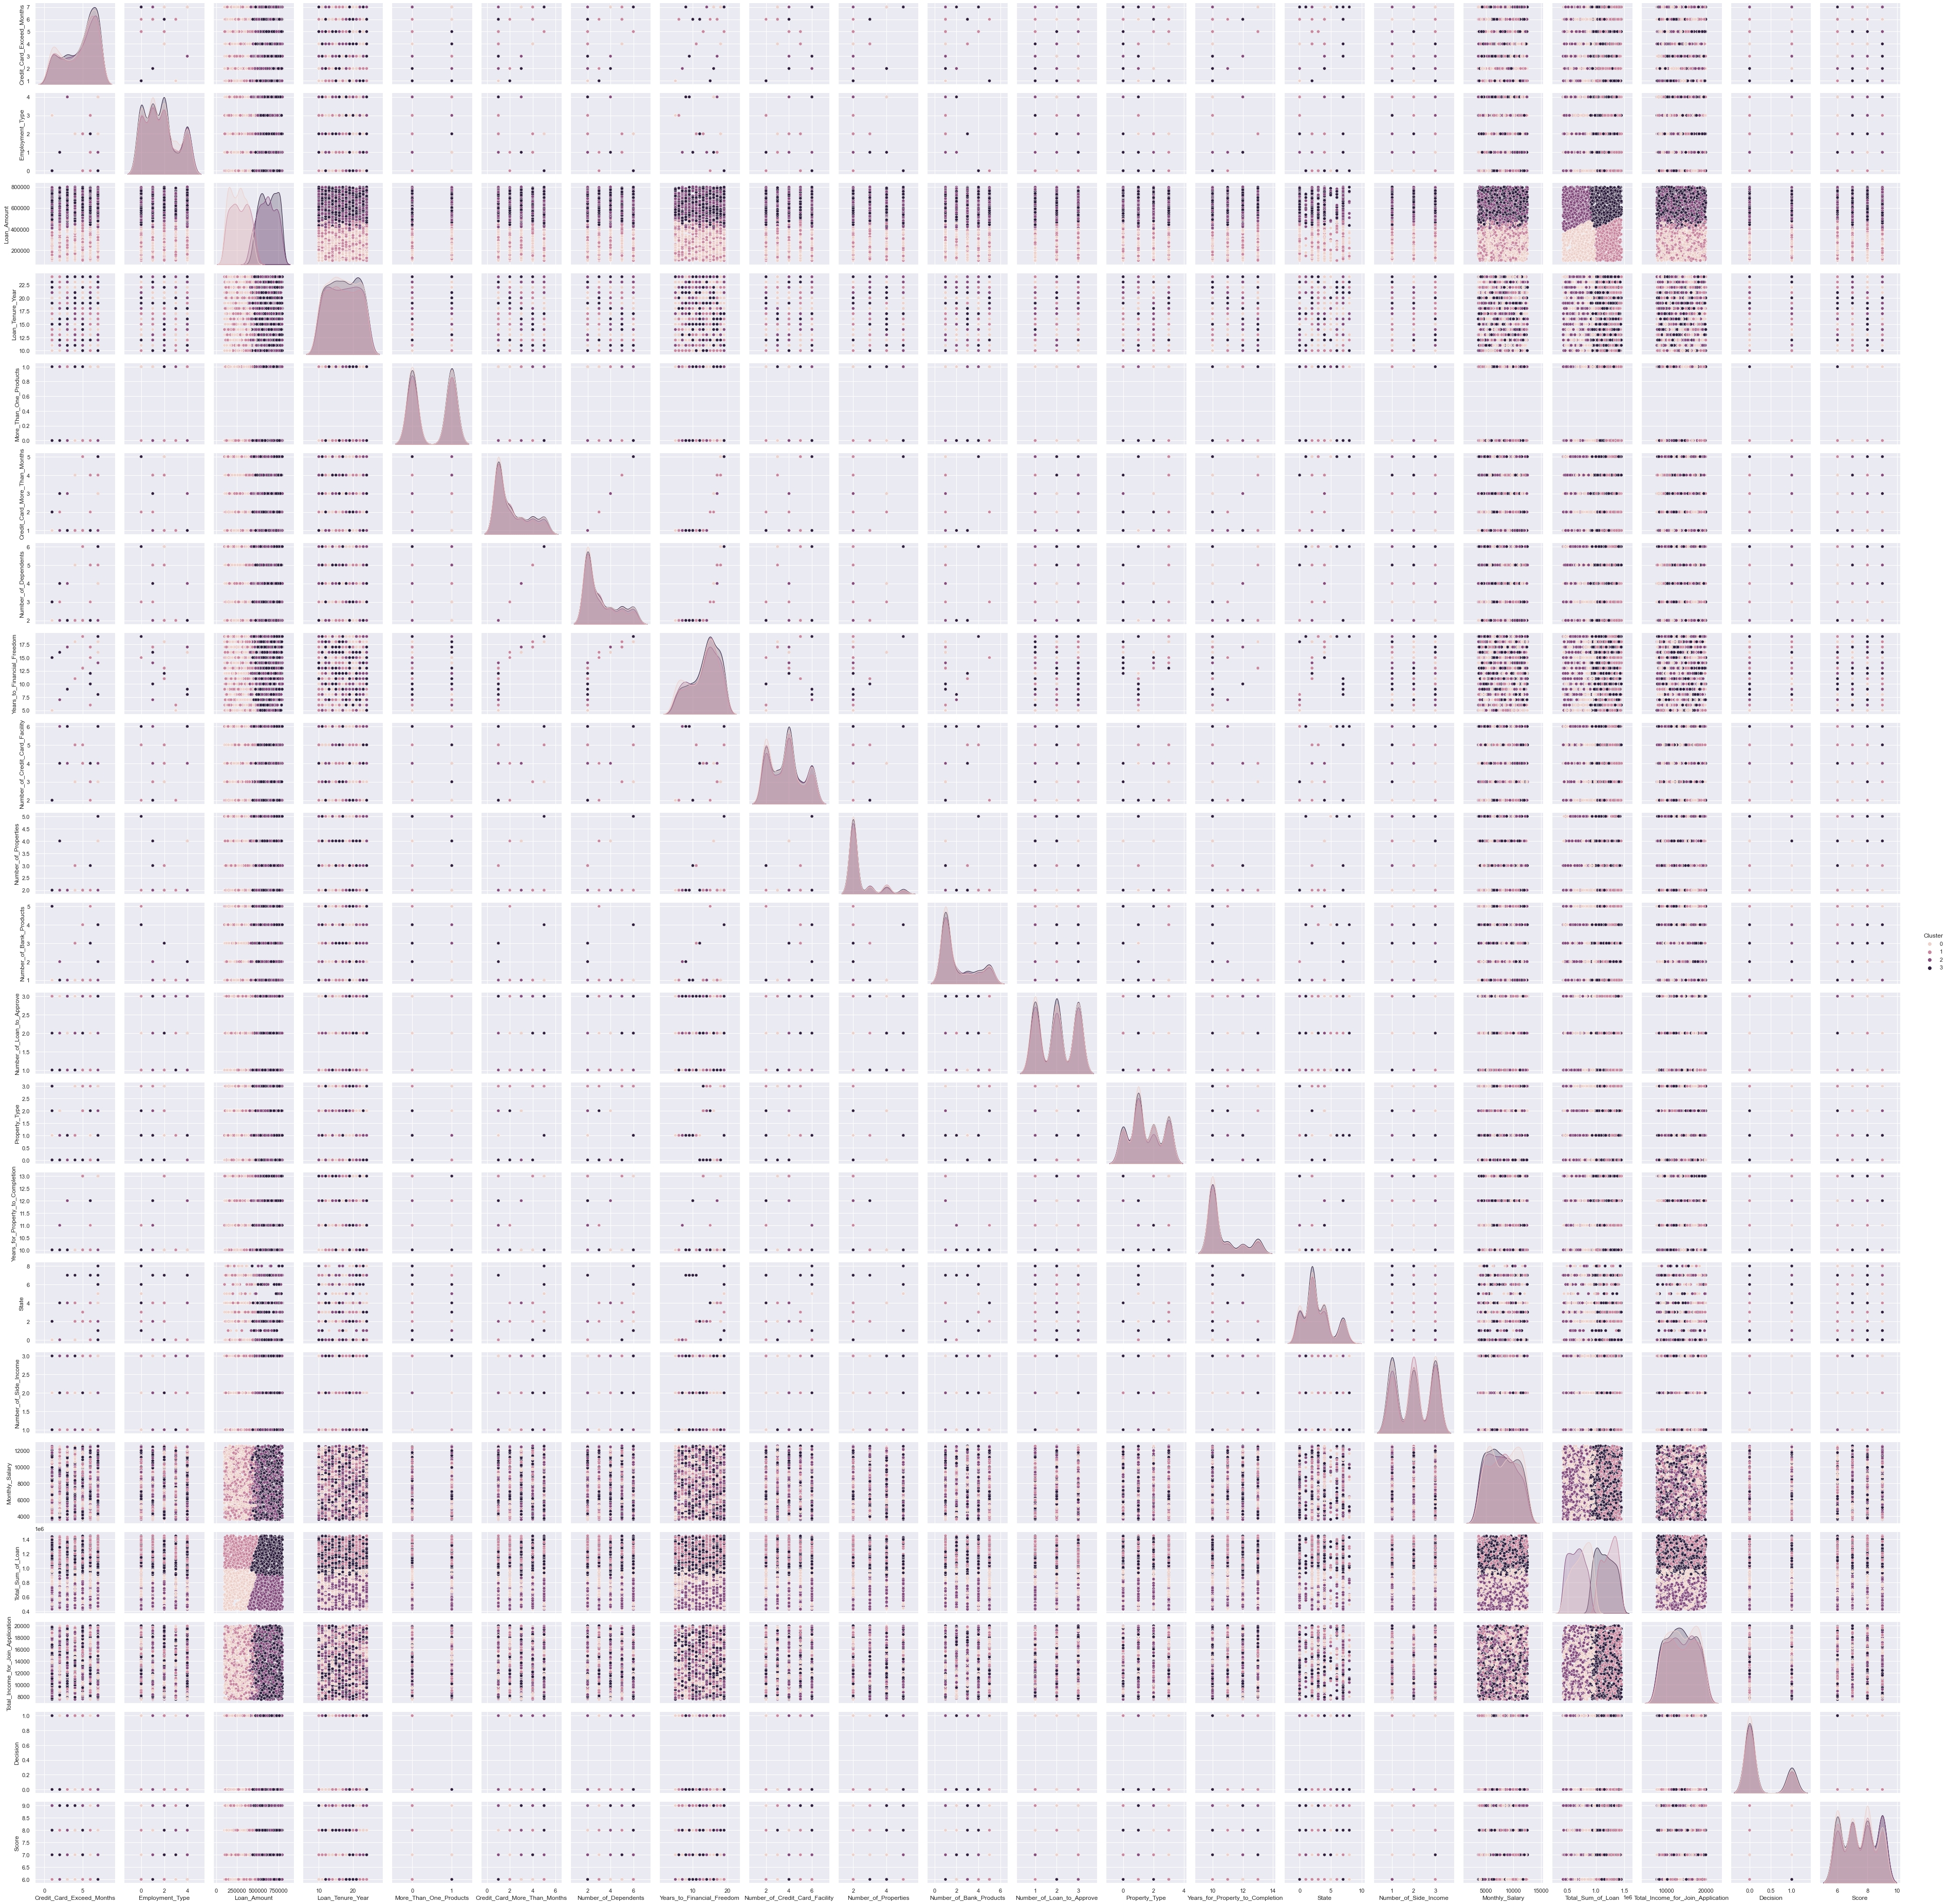

In [28]:
sns.pairplot(df_clustered, hue="Cluster")

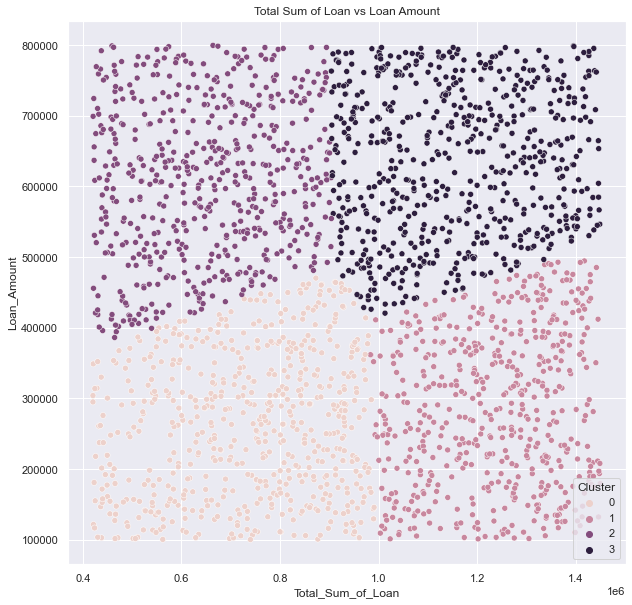

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_clustered, x="Total_Sum_of_Loan", y="Loan_Amount", hue = "Cluster", ax=ax)
ax.set_title("Total Sum of Loan vs Loan Amount")
plt.show()

As shown in the Figure above, there are 4 clusters represented by the label 0,1,2 and 3. They can be described as "low loan amount applied for, low total sum lof loan payable", "low loan amount applied for, high total sum lof loan payable", "high loan amount applied for, low total sum lof loan payable" and "high loan amount applied for, high total sum lof loan payable". 

## Split into train and test

In [30]:
df.Decision = df['Decision'].apply(str)
X = df.drop("Decision",axis=1)
y = df["Decision"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Train & Test Data using Random Forest

In [31]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7531914893617021


## Train & Test Data using SVM

In [32]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
ypred = svc.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7553191489361702


## Train & Test Data using K-neighbours Classifier

In [33]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
ypred = kn.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.6936170212765957


## Train & Test Data using Decision Tree

In [34]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
ypred = dtc.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.6574468085106383


## Train & Test Data using Gaussian Naive Bayes

In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
ypred = gnb.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7553191489361702


## Selection of classifiers
Among all the classifiers tested with default parameters, the 2 models, RF and SVM return identical accuracy score of 0.7511 and 0.7553 respentively. Thus, they are selected as classifier models for our project. Then, we perform random search and grid search to find the optimal parameters for RF and SVM respectively.

## Finding the optimal hyperparameters of Random Forest

In [36]:
from sklearn.model_selection import RandomizedSearchCV
criterion = ['gini','entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'criterion':criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'gini',
 'bootstrap': False}

## Run RF again with newly found optimal parameters

In [37]:
rf = RandomForestClassifier(n_estimators= 1200,
 min_samples_split= 10,
 min_samples_leaf= 4,
 max_features= 'sqrt',
 max_depth= 60,
 criterion= 'gini',
 bootstrap= True)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7553191489361702


 Note that the accuracy score increases  from 0.7511 to 0.7553 by a very small margin.

## Randomized Search again to double confirm the parameters

In [38]:
criterion = ['gini','entropy']
# Number of trees in random forest
n_estimators = [600,800,1000,1200,1400,1600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [40, 50, 60, 70, 80]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'criterion':criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'criterion': 'gini',
 'bootstrap': True}

Notice some of the optimal parameters are altered when we run the randomized search for the second time. However, min_samples_split, min_samples_leaf and max_depth have smaller values which will in return save computational costs.

In [39]:
rf = RandomForestClassifier(n_estimators= 1000,
 min_samples_split= 5,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 50,
 criterion= 'gini',
 bootstrap= True)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7553191489361702


With updated parameters from second randomized search, we still obtain the same accuracy score as compared to the parameters from the first randomized search.

In [40]:
#roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("ROC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print("Precision Score:", precision_score(y_test, ypred, average="binary", pos_label="0"))
print("F1 Score:", f1_score(y_test, ypred, average="binary", pos_label="0"))


Accuracy Score: 0.7553191489361702
ROC Score: 0.5426576852418862
Precision Score: 0.7553191489361702
F1 Score: 0.8606060606060607


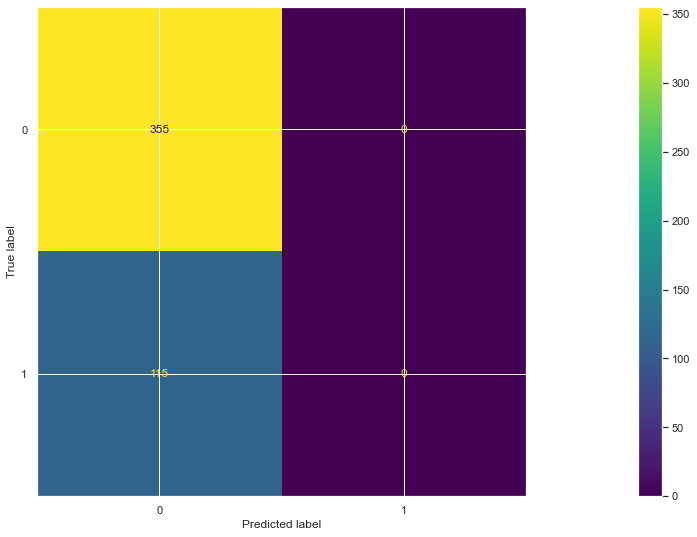

In [41]:
#Visualization of RF Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ypred)
plt.show()

In [42]:
with open("y_test1.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(y_test)
with open("ypred1.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(ypred)

## Find optimal parameters for SVM

In [44]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ..............................C=0.1, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [45]:
print(grid.best_estimator_)

SVC(C=0.1)


In [46]:
svc = SVC(kernel='rbf',C=0.1)
svc.fit(X_train, y_train)
ypred = svc.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, ypred))

Accuracy Score: 0.7553191489361702


There is no improvement in accuracy score using the updated parameters.

In [47]:
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("ROC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print("Precision Score:", precision_score(y_test, ypred, average="binary", pos_label="0"))
print("F1 Score:", f1_score(y_test, ypred, average="binary", pos_label="0"))

Accuracy Score: 0.7553191489361702
ROC Score: 0.5426576852418862
Precision Score: 0.7553191489361702
F1 Score: 0.8606060606060607


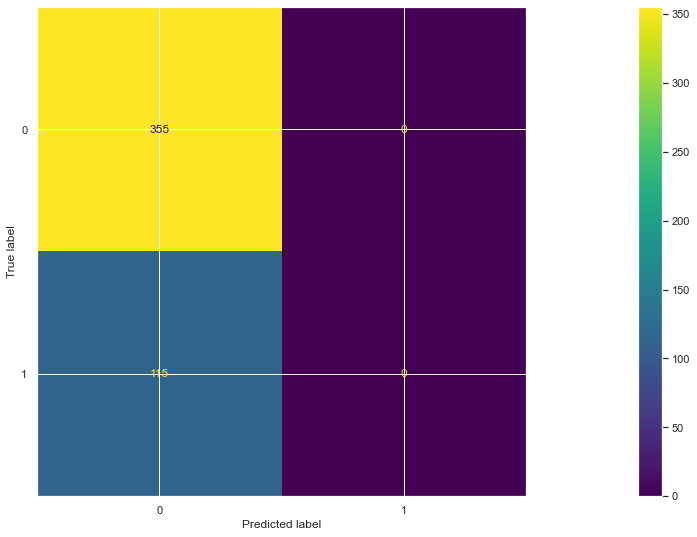

In [48]:
#Visualization of SVM Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ypred)
plt.show()

In [49]:
with open("y_test2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(y_test)
with open("ypred2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(ypred)

## Recommendation and Conclusion
As requested for this project, the metric used is accuracy which might not be suitable because of data imbalanced. The target variable "Decision" has two values "Accept" and "Reject", where number of occurences of "Accept" is significantly more than "Reject". As such, metrics such as F1 or AUC should be considered instead. Besides, k-fold cross-validation should be used because every subset of data will have its turn of being chosen as test set. The mean score of the metric will give us a more accurate out-of-sample accuracy. 

The accuracy in both RF and SVM models have negligible increment prolly due to the models chosen are not suitable for our problem. It is suggested that more classifier models are tested. Again, accuracy alone is insufficient to confirm one model is better than the other. 

As a conclusion, RF and SVM both has accuracy of approximately 0.75 which can be considered as good models. However, if we evaluate the models using F1-score instead, we get 0.86 instead where the models are excellent. 